# Labyrinth

### Workshop Goal:
Implement a genetic algorithm to find a path through a maze from the entry point (1,1) to the exit (10,10).

During this workshop, you'll:
* represent movement with genes,
* define a fitness function,
* evolve solutions over time using genetic operations.

## Libraries

Import all the required libraries.
Make sure the file projekt01_labirynt_wizualizacje.py is available in your directory. That file contains visualization functions. If you don’t have it, you can create placeholder functions or ask for a backup copy.

In [1]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 1.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pygad
import tqdm
import copy
from time import time

import matplotlib.patches as patches
import matplotlib.animation as animation

## Visualisation

In [4]:
def draw_labyrinth(plot_object, labyrinth: np.ndarray):
    """Function that draws empty maze (without a route) on the object
    'plot_object'"""
    for i in range(len(labyrinth)):
        """Iteration on raws"""
        for j in range(len(labyrinth[i])):
            """Iteration on columns"""
            if labyrinth[i, j] == 1:
                """Drawing walls"""
                rect = patches.Rectangle(
                    (j, i), 1, 1, linewidth=1, edgecolor='black', facecolor='black'
                )
            else:
                """Drawing empty box"""
                rect = patches.Rectangle(
                    (j, i), 1, 1, linewidth=1, edgecolor='grey', facecolor='white'
                )
            plot_object.add_patch(rect)

    """Final settings"""
    plot_object.set_xlim(0, 12)
    plot_object.set_ylim(0, 12)
    plot_object.invert_yaxis()
    plot_object.set_aspect('equal')


def see_route(labyrinth: np.ndarray, moves_mapping: dict, steps: list,
              gif_filename='labirynt.gif', summary_filename='labirynt_summary.png'):
    """Function that takes as input a matrix representing a labyrinth, a dictionary that matches the movement code
    to the change of the appropriate coordinates - in a matrix from the numpy library, the row coordinate is first, then the column coordinate!

    The function outputs a GIF animation of a given route through the labyrinth and a PNG graphic with a summary of the entire route.
    """
    start_pos = (1, 1)
    fig, ax = plt.subplots()

    """Draw empty maze"""
    draw_labyrinth(plot_object=ax, labyrinth=labyrinth)

    """Creating a route based on steps"""
    path_x, path_y = [start_pos[1] + 0.5], [start_pos[0] + 0.5]  # the path starts in the middle of the input field, hence 0.5
    pos = list(start_pos)
    for step in steps:
        move = moves_mapping[int(step)]
        pos[0] += move[0]
        pos[1] += move[1]
        path_x.append(pos[1] + 0.5)  # shift by 0.5 so that the lines are "centered" and not along the edges of the fields
        path_y.append(pos[0] + 0.5)  # shift by 0.5 so that the lines are "centered" and not along the edges of the fields

    def update(num, path_x, path_y, line):  # inside a function you can create a "local" function
        """Function to update animations"""
        line.set_data(path_x[:num], path_y[:num])
        return line,

    """Initializing the route line"""
    line, = ax.plot([], [], lw=2, color='red')

    """Animation of a route along the appropriate coordinates with a given interval, defining how quickly the frames change in the final GIF."""
    ani = animation.FuncAnimation(fig, update, frames=len(path_x), fargs=[path_x, path_y, line], interval=200,
                                  blit=True)

    """Axis settings"""
    plt.xlim(0, 12)
    plt.ylim(0, 12)
    plt.gca().invert_yaxis()

    """Saving animation as GIF"""
    ani.save(gif_filename, writer='imagemagick')
    # print(f"Animation of the route through the maze has been generated.")

    """Drawing the entire route on a PNG graphic"""
    fig, ax = plt.subplots()  # wreuses local variables
    draw_labyrinth(plot_object=ax, labyrinth=labyrinth)  # we draw an empty maze again
    ax.plot(path_x, path_y, lw=2, color='red')  # we add the entire generated route

    """Axis settings"""
    plt.xlim(0, 12)
    plt.ylim(0, 12)
    plt.gca().invert_yaxis()

    """Saving picture as  PNG"""
    plt.savefig(summary_filename)
    plt.close()
    # print(f"A graphic showing the entire route through the labyrinth was made.")

## Maze

The maze is encoded using a matrix of elements 0 and 1. Zero denotes a permitted field that can be entered, and a black field denotes a wall; these fields cannot be entered. Including the walls on the border of the maze, it measures 12x12, so the coordinates in Python will be numbered from 0 to 11. The entrance is in field (1,1), and the exit is in field (10,10).

Take note:
1 represents a wall (obstacle),
0 represents a valid path.

In [5]:
labyrinth = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
            [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1],
            [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1],
            [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
            [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1],
            [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        ])

Check the moves_mapping dictionary. Think about:
* Which directions are allowed?
* What does each move do?

Think of each move as a vector that changes the current position. The genes are just sequences of such vectors.

The matrix uses [y][x] indexing: labyrinth[y][x].

In [6]:
gene_space = [0, 1, 2, 3, 4]
moves_mapping = {
    0: (0, 0),    # without move
    1: (0, -1),   # left
    2: (0, 1),    # right
    3: (-1, 0),   # up
    4: (1, 0)     # down
}

## Algorithm Parameters

Try to understand which parameters affect **exploration** and which focus on **exploitation**.

For quicker tests, reduce *num_generations* and *sol_per_pop*.

In [7]:
exit_labyrinth = {'y': 10, 'x': 10}  #coordinates of the "exit" from the maze
num_generations = 4000
sol_per_pop = 500 #number of chromosomes in each generation
num_parents_mating = 250
num_genes = 30
selection = "tournament" # For selection methods, look at: https://pygad.readthedocs.io/en/latest/pygad.html#parent-selection-methods
mutation = "random"
mutation_prob = 0.15
k_tournament = 10 #size of tournament pool size
stop_criteria = "reach_1"

## Simple fitness function

Try to define a fitness function based only on the Manhattan distance from the final position to the exit.

*Hint: Use abs(x_exit - x_pos) + abs(y_exit - y_pos) and normalize the result. Don’t worry about hitting walls or repeating steps yet.*

In [8]:
def fitness_fun(genetic_algorithm_instance, route, route_idx):
    """We use Taxi metrics to evaluate routes through the maze"""
    position = {'y': 1, 'x': 1}  # start in (1,1)

    for move in route:  # we change position depending on the movement made
        new_y, new_x = position.get('y') + moves_mapping.get(move)[0], position.get('x') + moves_mapping.get(move)[1]

        if 0 <= new_y <= 11 and 0 <= new_x <= 11:
            """After verifying that the new coordinates are inside the maze (i.e., they fit into the matrix),
            we check if they represent a legal field:
            """
            if labyrinth[new_y, new_x] == 0:
                position['x'], position['y'] = new_x, new_y
        else:
            print(f"We got the coordinates x={new_x} and y={new_y} outside the labyrinth.")

    """First, we calculate the auxiliary variables, for readability:"""
    x_distance = abs(exit_labyrinth.get('x') - position.get('x'))
    y_distance = abs(exit_labyrinth.get('y') - position.get('y'))
    sum_exit_coordinates = exit_labyrinth.get('x') + exit_labyrinth.get('y')

    """Actual fitness value, maximum 1:"""
    fitness_val = (sum_exit_coordinates - x_distance - y_distance) / sum_exit_coordinates

    return fitness_val

## Function usage and route visualization

  0%|          | 0/10 [00:00<?, ?it/s]

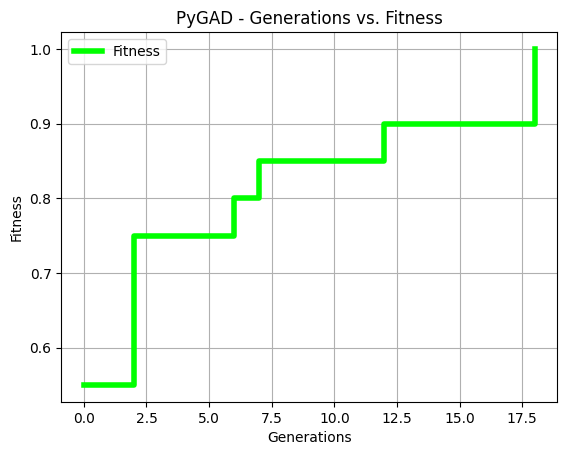

 10%|█         | 1/10 [00:13<02:03, 13.75s/it]

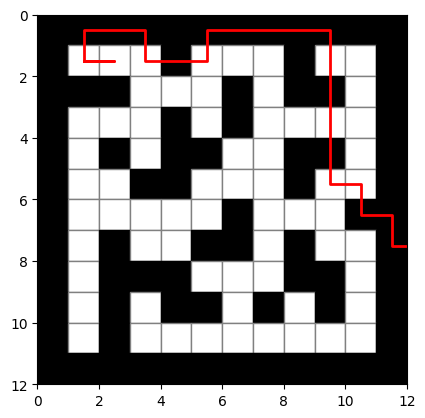

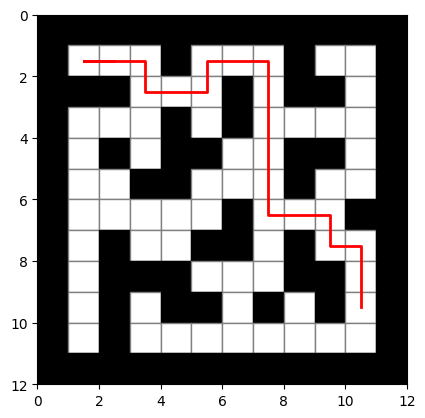

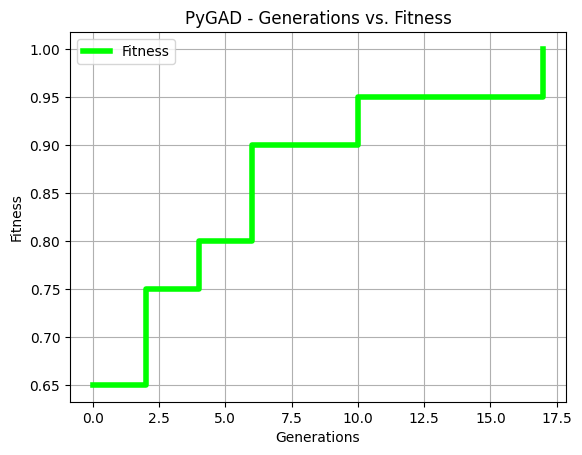

 20%|██        | 2/10 [00:28<01:53, 14.21s/it]

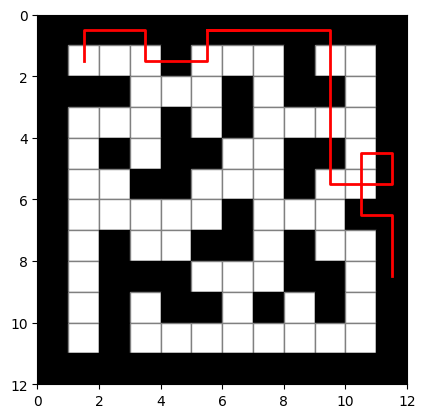

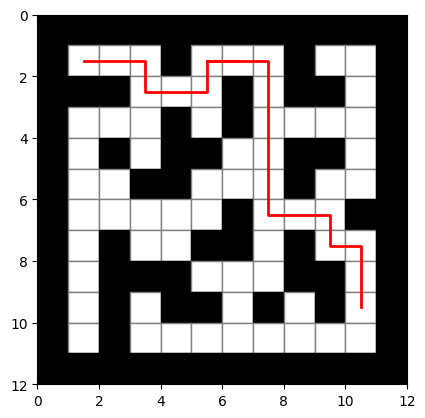

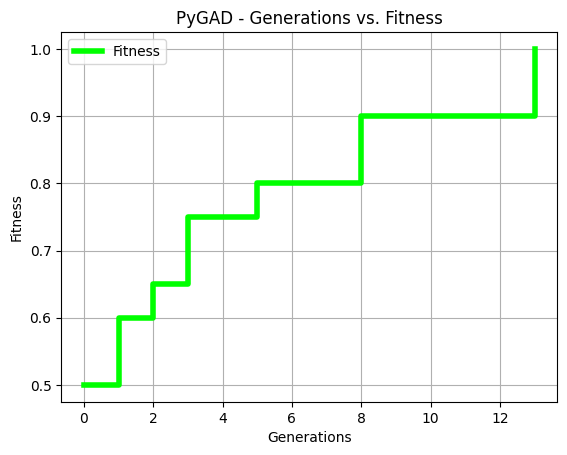

 30%|███       | 3/10 [00:39<01:31, 13.05s/it]

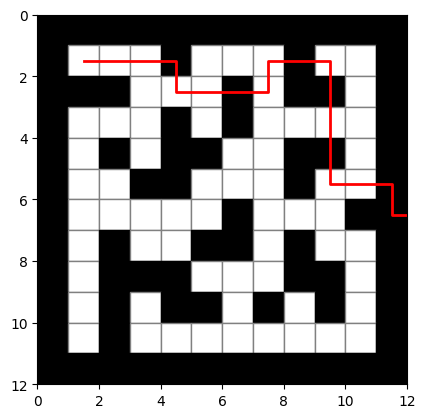

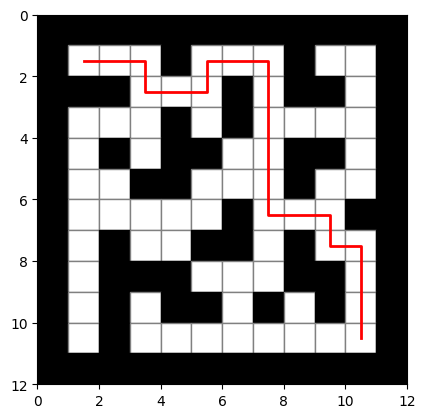

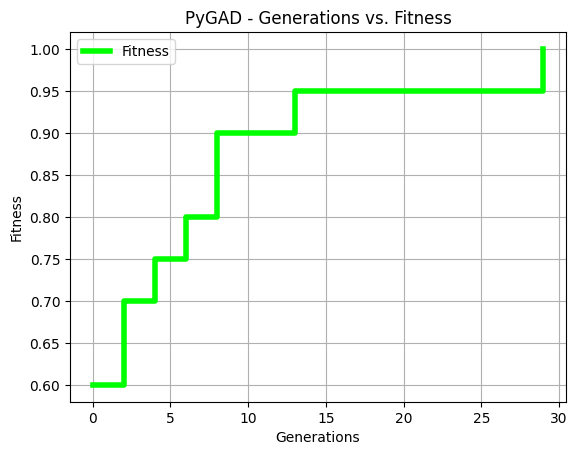

 40%|████      | 4/10 [00:52<01:17, 12.99s/it]

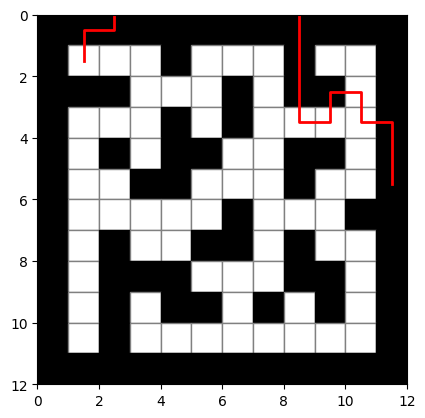

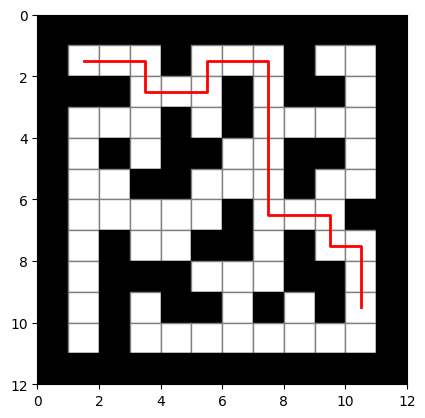

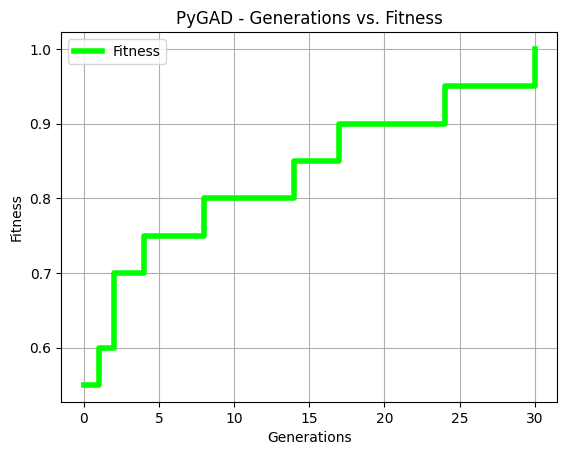

 50%|█████     | 5/10 [01:06<01:05, 13.16s/it]

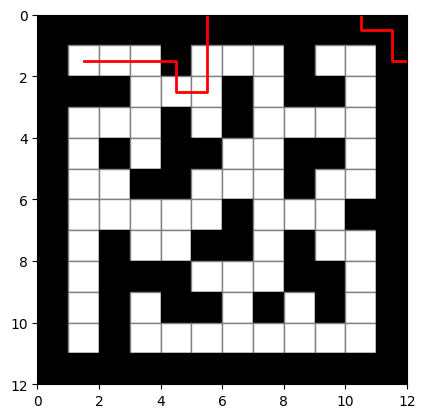

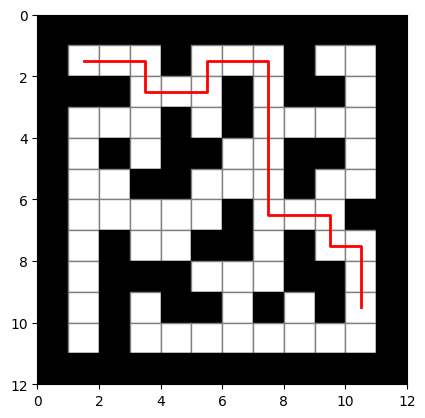

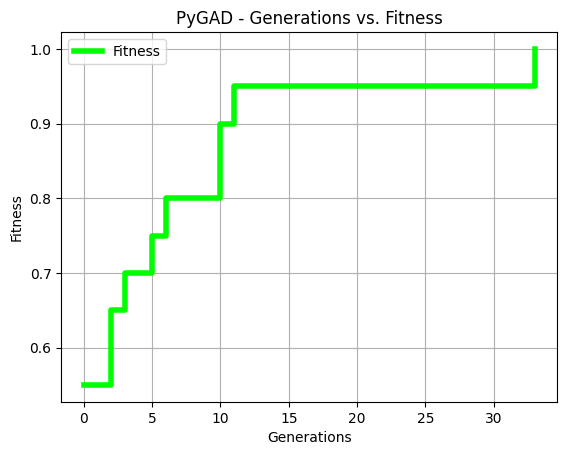

 60%|██████    | 6/10 [01:19<00:53, 13.30s/it]

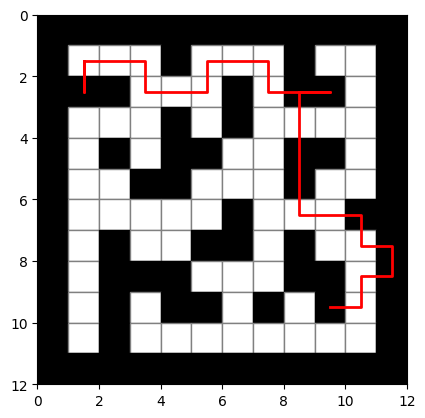

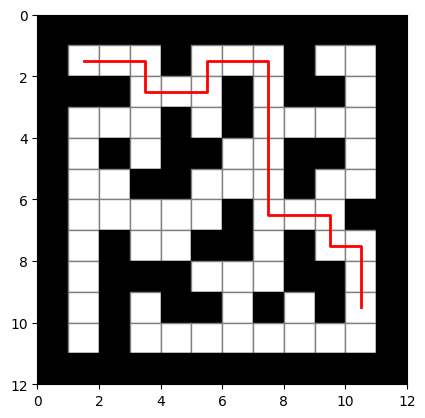

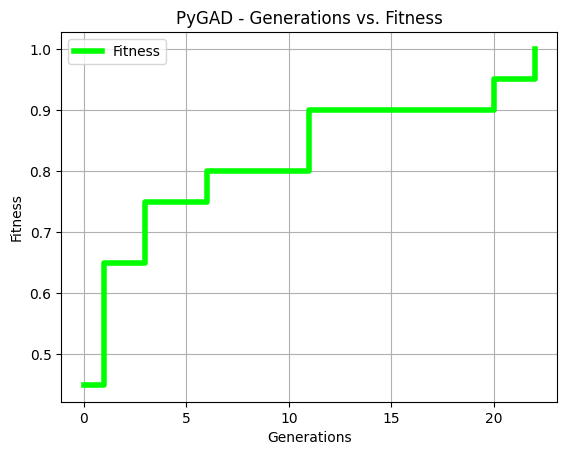

 70%|███████   | 7/10 [01:32<00:39, 13.01s/it]

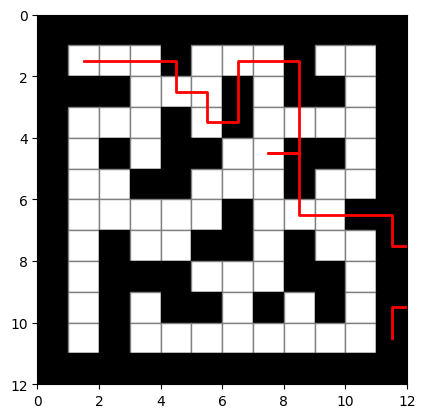

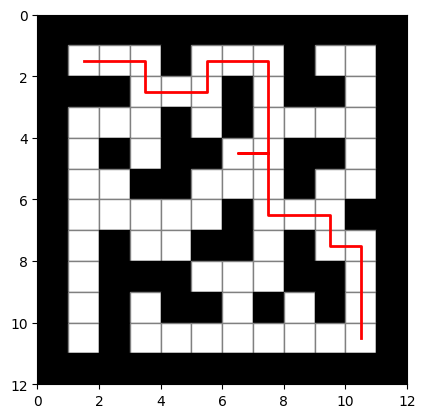

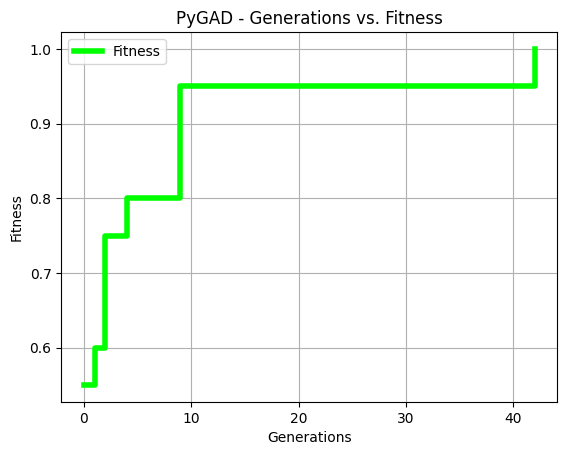

 80%|████████  | 8/10 [01:46<00:27, 13.52s/it]

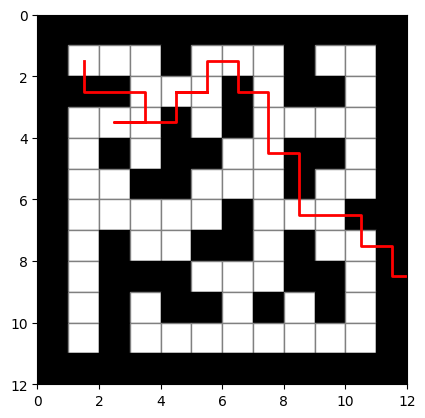

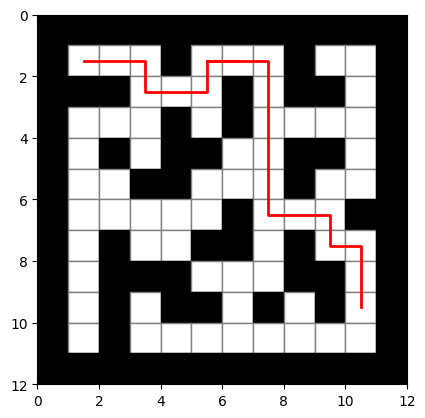

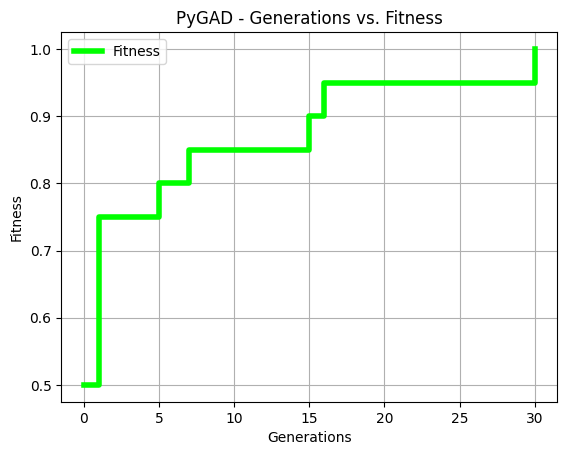

 90%|█████████ | 9/10 [02:00<00:13, 13.59s/it]

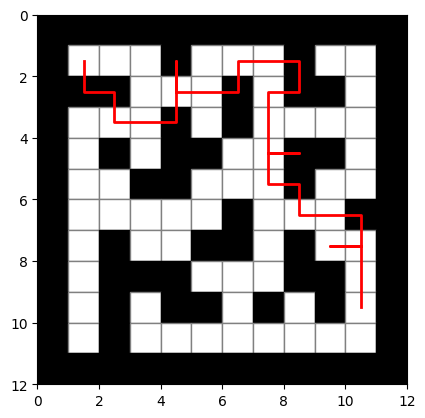

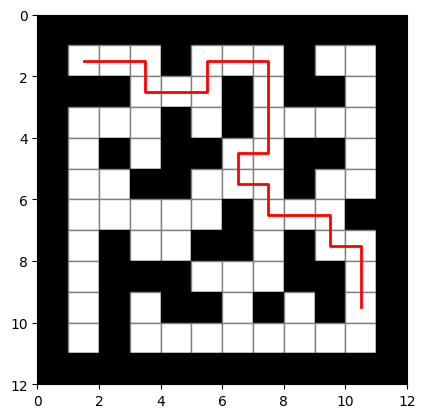

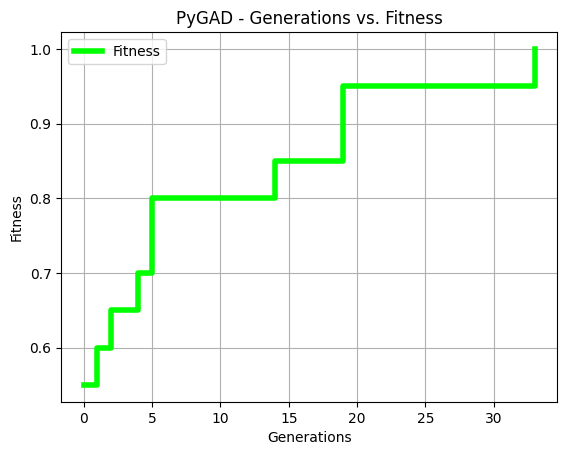

100%|██████████| 10/10 [02:14<00:00, 13.47s/it]


Average running time of genetic algorithm: 3.016947031021118
Average fitness value of the best solution: 1.0
Average number of generations to obtain the best solution:26.7
Results history: 

[2. 1. 3. 2. 2. 4. 2. 2. 3. 2. 2. 2. 2. 4. 4. 4. 4. 4. 2. 4. 2. 4. 2. 2.
 4. 4. 1. 2. 2. 4.]
[3. 2. 2. 4. 2. 2. 3. 0. 2. 1. 2. 2. 2. 2. 4. 4. 4. 4. 4. 2. 3. 0. 2. 4.
 1. 4. 2. 4. 4. 4.]
[2. 2. 2. 4. 2. 2. 2. 3. 2. 2. 4. 4. 4. 4. 2. 2. 4. 2. 0. 2. 4. 2. 3. 4.
 2. 2. 4. 2. 4. 4.]
[3. 2. 3. 2. 3. 2. 4. 2. 2. 3. 0. 0. 2. 2. 0. 4. 4. 0. 4. 4. 4. 2. 3. 2.
 4. 2. 4. 4. 0. 4.]
[2. 2. 2. 4. 2. 3. 3. 3. 3. 2. 3. 2. 3. 3. 2. 4. 2. 2. 4. 4. 4. 4. 2. 4.
 2. 4. 2. 4. 4. 4.]
[4. 0. 3. 2. 2. 4. 2. 0. 2. 3. 2. 2. 4. 2. 2. 1. 4. 4. 0. 4. 4. 2. 2. 4.
 2. 4. 1. 4. 1. 4.]
[2. 2. 2. 4. 2. 0. 4. 2. 3. 3. 2. 2. 4. 0. 4. 4. 1. 2. 4. 4. 2. 2. 2. 4.
 2. 4. 4. 1. 4. 4.]
[4. 2. 2. 4. 1. 2. 2. 3. 2. 0. 1. 2. 3. 2. 4. 2. 4. 4. 2. 4. 4. 2. 2. 4.
 2. 4. 2. 2. 4. 4.]
[4. 2. 4. 2. 2. 3. 3. 4. 2. 2. 3. 2. 2. 4. 1. 4. 4. 2. 1. 4. 2. 4

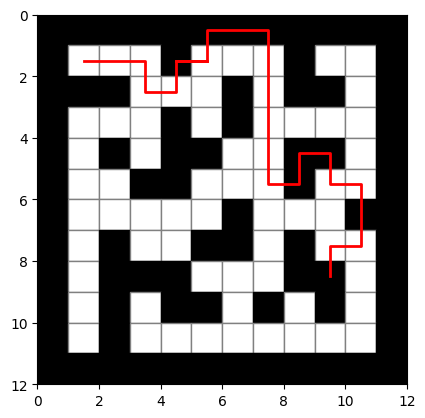

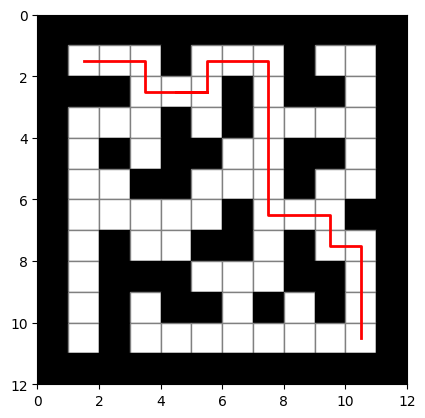

In [9]:
def example():
    # Example of using the route visualization function
    steps = [2, 2, 4, 4, 4, 1, 4, 2, 2, 1, 4, 4, 1, 1, 1, 4, 2, 2, 4, 2, 4, 2]
    see_route(steps=steps, labyrinth=labyrinth, moves_mapping=moves_mapping)
    print("Files generated correctly.")

    # Creating an empty maze for analysis
    fig, ax = plt.subplots()
    draw_labyrinth(plot_object=ax, labyrinth=labyrinth)
    plt.savefig("empty_maze.png")
    print("Empty maze created.")


def main():
    """Main function executing, applying the genetic algorithm to the maze according to the settings in global variables and using the visualization functions defined in the Visualisation part script above.
    """
    fitness_list = []
    times = []
    output_list = []
    generations_no = []  # generation number in a given iteration in which the best solution was achieved

    for i in tqdm.tqdm(range(10)):
        start = time()  # we check the time at the start

        ga_instance = pygad.GA(
            gene_space=gene_space,
            num_genes=num_genes,
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=fitness_fun,
            sol_per_pop=sol_per_pop,
            parent_selection_type=selection,
            mutation_type=mutation,
            mutation_probability=mutation_prob,
            stop_criteria=stop_criteria,
            suppress_warnings=True,
            K_tournament=k_tournament
        )

        ga_instance.run()  # we run the genetic algorithm
        end = time()  # we measure time at the end
        times.append(end - start)

        """We manually visualize fitness history across generations."""
        fig, ax = plt.subplots()  # we create a separate figure for fitness history charts
        fitness = ga_instance.best_solutions_fitness  # values ​​on axis 0y
        generations = list(range(len(fitness)))  # values ​​on axis 0x

        ax.plot(generations, fitness, color="lime", linewidth=4, drawstyle='steps-post', label='Fitness')

        ax.set_xlabel("Generations")
        ax.set_ylabel("Fitness")
        ax.set_title("PyGAD - Generations vs. Fitness")
        ax.legend()
        ax.grid(True)
        plt.show()

        """We remember the solution parameters:"""
        solution, solution_fitness, solution_idx = ga_instance.best_solution()
        generations_no.append(ga_instance.best_solution_generation)
        fitness_list.append(solution_fitness)
        output_list.append(solution)

        """We visualize the results (the routes that the chromosomes wanted to take)"""
        gif_filename = 'chromosome_animation' + str(i) + '.gif'
        picture_filename = 'chromosome_picture' + str(i) + '.png'
        see_route(labyrinth=labyrinth, moves_mapping=moves_mapping, steps=output_list[-1],
                  gif_filename=gif_filename, summary_filename=picture_filename)

        """We visualize the actual route, omitting the steps of entering a prohibited field"""
        x, y = 1, 1
        history = []

        for step in output_list[-1]:
            new_y, new_x = y + moves_mapping.get(step)[0], x + moves_mapping.get(step)[1]
            if 0 <= new_y <= 11 and 0 <= new_x <= 11:
                """After verifying that the new coordinates are inside the maze (i.e., they fit into the matrix),
                we check if they represent a legal field:
                """
                if labyrinth[new_y, new_x] == 0:
                    x, y = new_x, new_y
                    history.append(step)
                else:
                    history.append(0)
            else:
                print(f"We got the coordinates x={new_x} and y={new_y} outside the maze (with visualization).")

        gif_filename = 'actual_route_animation' + str(i) + '.gif'
        picture_filename = 'actual_route_picture' + str(i) + '.png'
        see_route(labyrinth=labyrinth, moves_mapping=moves_mapping, steps=history,
                  gif_filename=gif_filename, summary_filename=picture_filename)

    print(f"Average running time of genetic algorithm: {np.mean(times)}")
    print(f"Average fitness value of the best solution: {np.mean(fitness_list)}")
    print(f"Average number of generations to obtain the best solution:{np.mean(generations_no)}")

    print(f"Results history: \n")
    for j in range(len(output_list)):
        print(output_list[j])


if __name__ == "__main__":
    main()

## Additional task: Extended Fitness Function with Rewards and Penalties

Try to implement the improved version of the fitness function.

Include:

* bonus for reaching the exit (bonus_point),

* penalty for repeating positions (pos_repeat_point),

* penalty for hitting walls (hitting_a_wall_point).

*Hint: Track position history using a list to detect cycles or inefficient loops.*

In [10]:
"""Weighting of reward and penalty points:"""
bonus_point = 2  # for prizes
pos_repeat_point = 1  # to the penalty for repeating a position
hitting_a_wall_point = 1.25  # to the penalty for wasting movement on bouncing off wallsy
max_bonus = 10 * bonus_point  # we wait for a maximum of 10 steps at the finish line, which can be reached in 20 out of 30 steps

In [11]:
def fitness_fun_new(genetic_algorithm_instance, route, route_idx):
    """We use the Taxi metric to evaluate routes through the maze. Additionally, we assign penalties and rewards for individual
    behaviors so that the routes proposed by the chromosomes are as close as possible to the actual ones, after taking into account "bounces" off the walls.
    """
    position = {'y': 1, 'x': 1}  # zaczynamy w (1,1)

    """To avoid the hassle of the 'mutable' property of dictionaries, we store a copy of the initial state of the position dictionary in the position history list,
    rather than assigning a dynamic data structure to the list.
    """
    history = [copy.deepcopy(position)]
    is_probem = 0  # the initial value of the problem counter to which we assign penalty points
    bonus = 0  # the initial bonus value to which we add the reward points

    for move in route:  # we change position depending on the movement made

        if position.get('x') == exit_labyrinth.get('x') and position.get('y') == exit_labyrinth.get('y') and move == 0:
            bonus += bonus_point  # bonus for staying in the finish line
            continue

        new_y, new_x = position.get('y') + moves_mapping.get(move)[0], position.get('x') + moves_mapping.get(move)[1]

        """We check if the new coordinates point to an allowed field:"""
        if labyrinth[new_y, new_x] == 0:
            position['x'], position['y'] = new_x, new_y
            history.append(copy.deepcopy(position))

            """We check if a penalty should be assigned for repeating an item:"""
            if history.count(position) > 1:
                is_probem += pos_repeat_point
        else:  # the field the chromosome wants to enter is not allowed!
            is_probem += hitting_a_wall_point

    """we calculate the auxiliary variables, for readability:"""
    x_distance = abs(exit_labyrinth.get('x') - position.get('x'))
    y_distance = abs(exit_labyrinth.get('y') - position.get('y'))
    sum_exit_coordinates = exit_labyrinth.get('x') + exit_labyrinth.get('y')

    """Actual fitness value, maximum 1:"""
    fitness_val = (sum_exit_coordinates - x_distance - y_distance) * 2  # using taxi metric
    fitness_val += bonus  # we add reward points for waiting in the finish line "until the end"
    fitness_val -= is_probem  # we subtract penalty points
    fitness_val = fitness_val / (sum_exit_coordinates * 2 + max_bonus)

    return fitness_val

  0%|          | 0/10 [00:00<?, ?it/s]

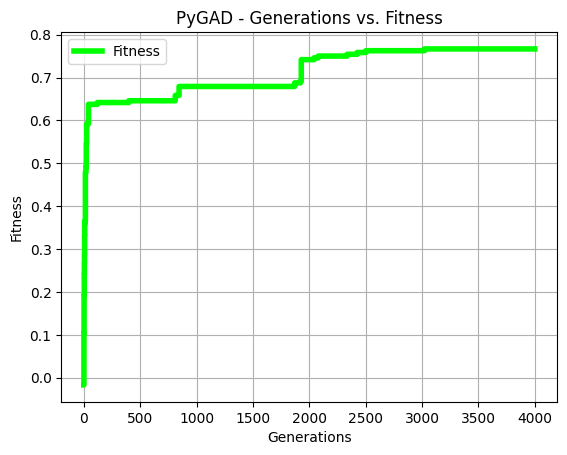

 10%|█         | 1/10 [10:09<1:31:22, 609.12s/it]

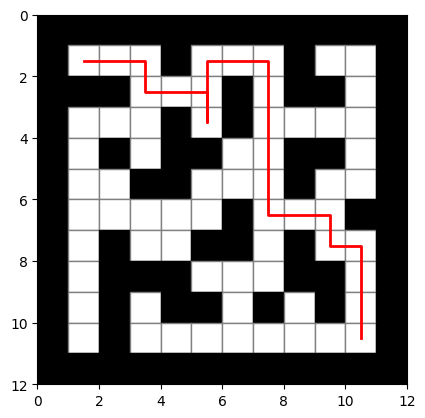

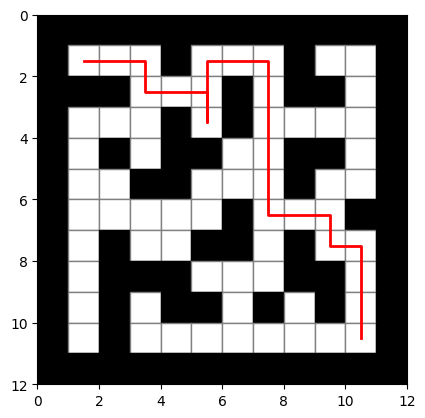

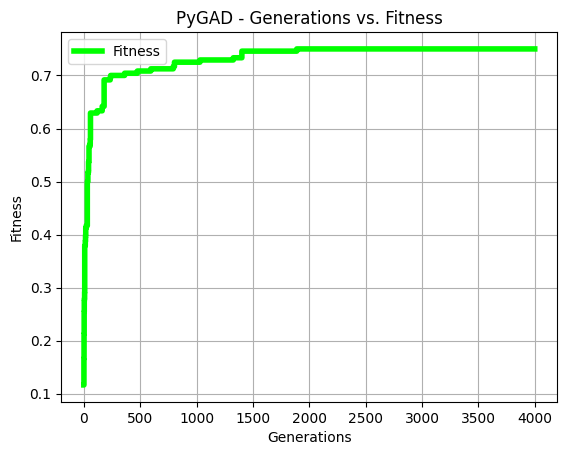

 20%|██        | 2/10 [20:36<1:22:41, 620.13s/it]

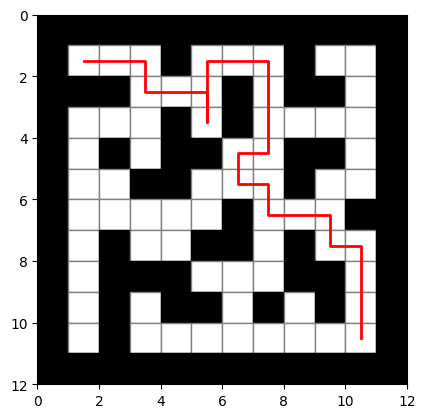

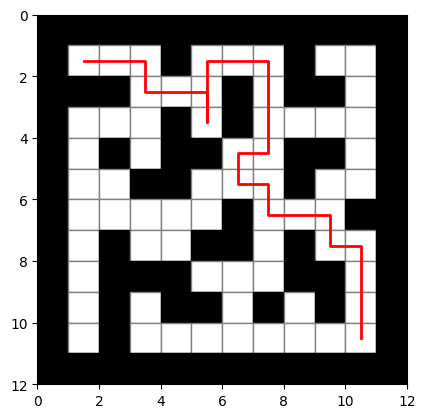

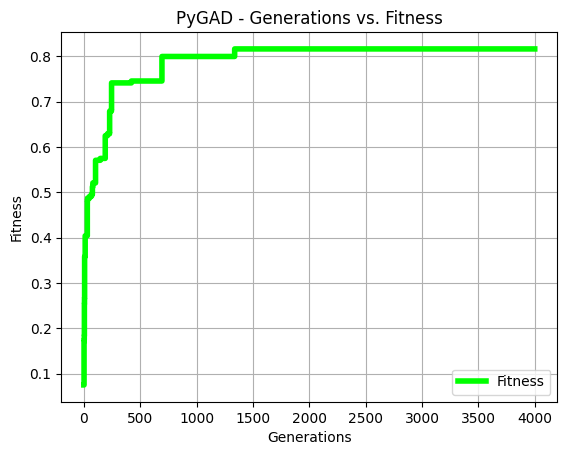

 30%|███       | 3/10 [31:17<1:13:26, 629.56s/it]

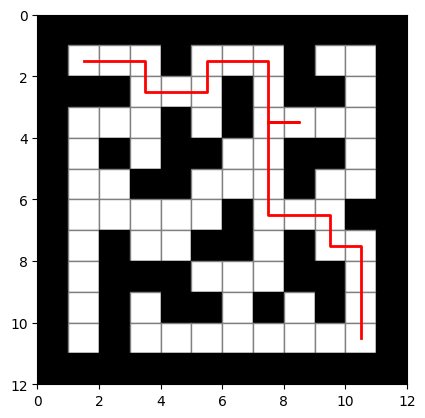

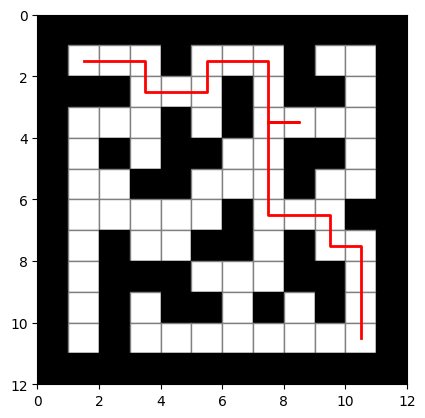

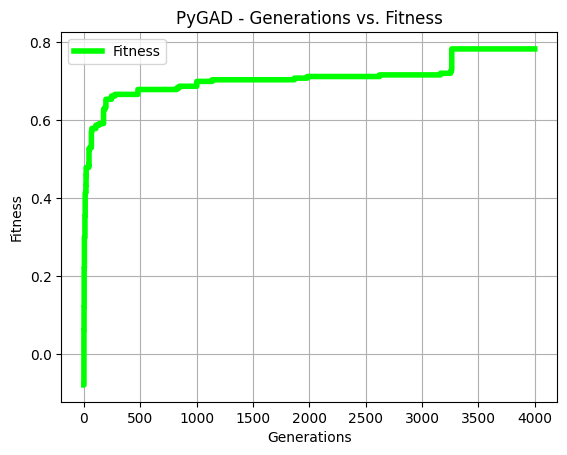

 40%|████      | 4/10 [41:30<1:02:16, 622.82s/it]

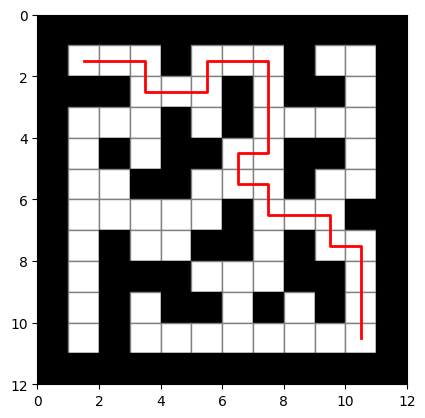

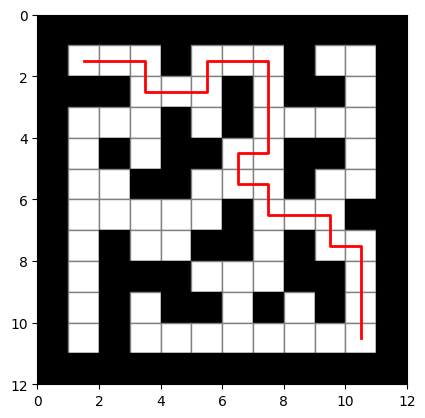

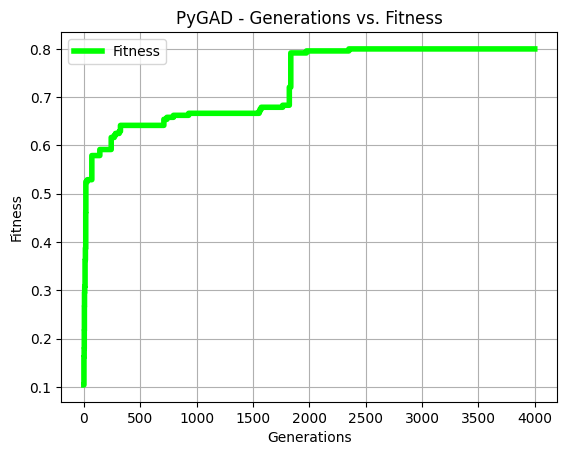

 50%|█████     | 5/10 [51:54<51:55, 623.18s/it]  

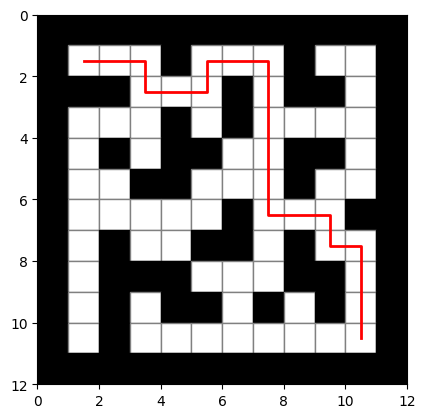

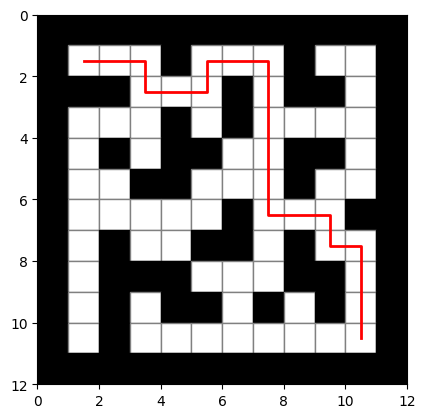

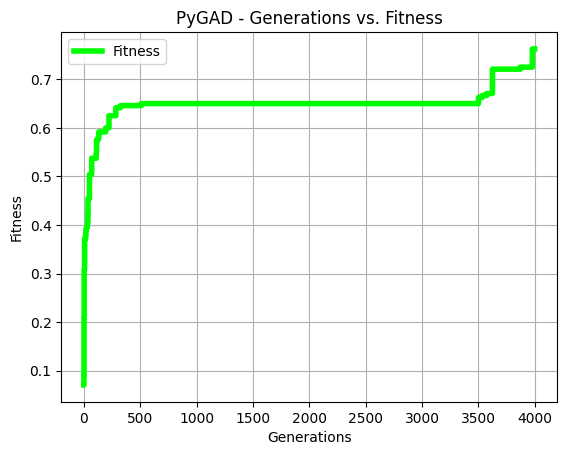

 60%|██████    | 6/10 [1:01:58<41:07, 616.82s/it]

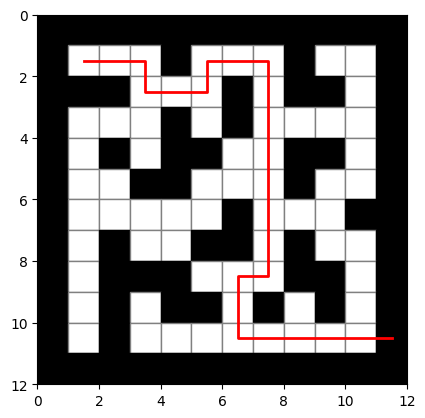

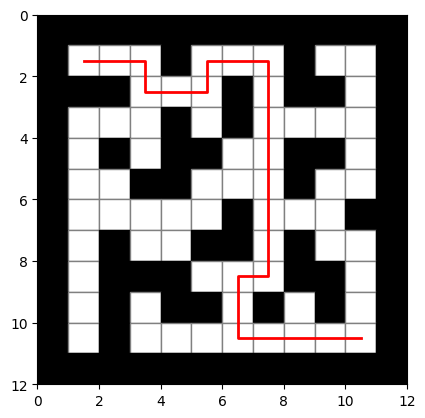

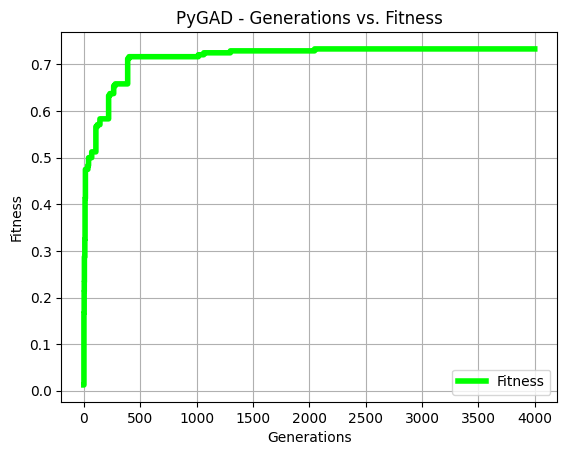

 70%|███████   | 7/10 [1:11:58<30:34, 611.39s/it]

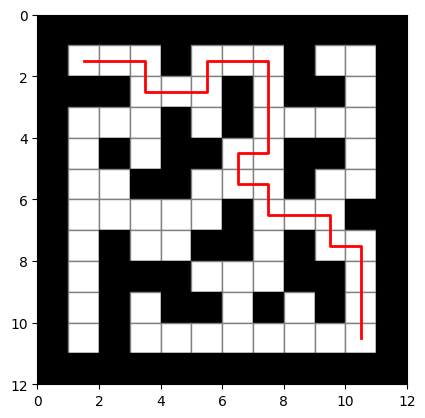

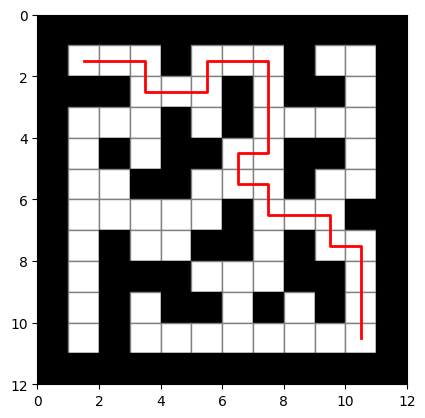

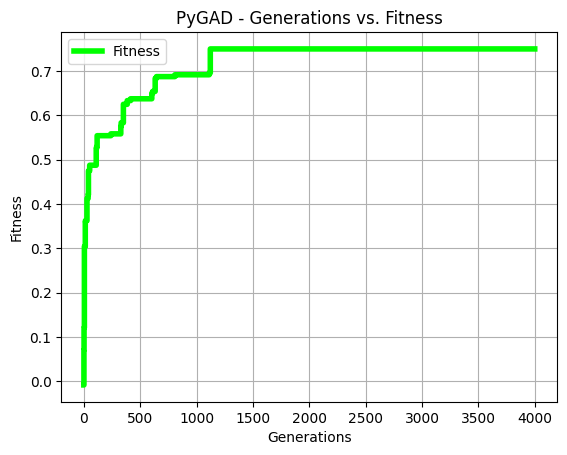

 80%|████████  | 8/10 [1:22:30<20:35, 617.91s/it]

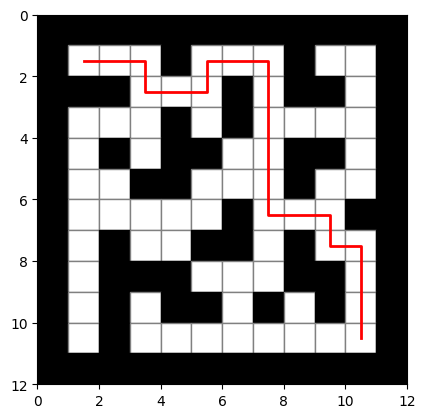

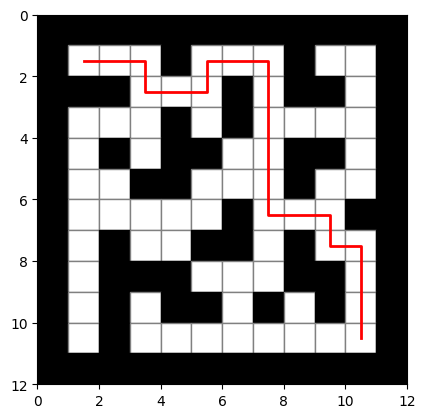

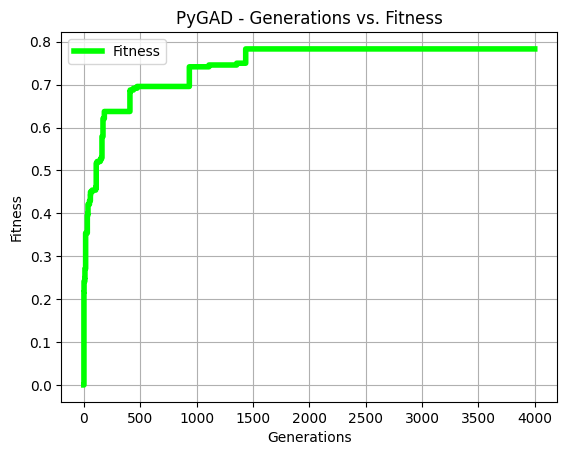

 90%|█████████ | 9/10 [1:33:04<10:23, 623.01s/it]

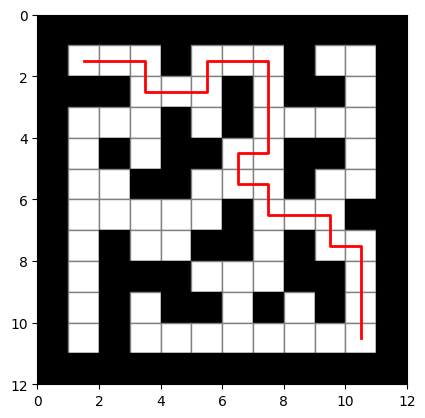

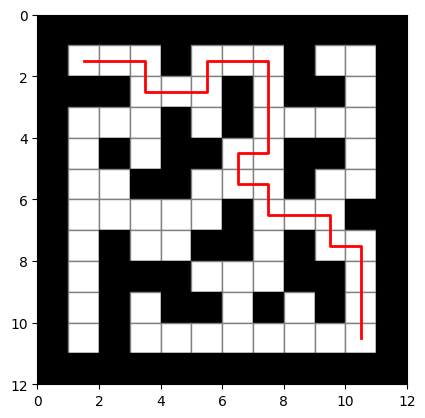

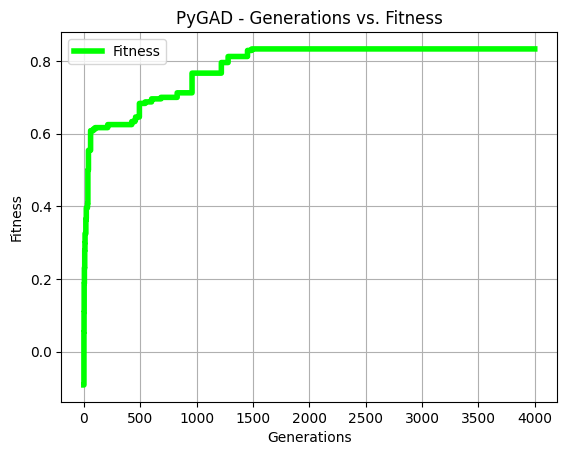

100%|██████████| 10/10 [1:43:52<00:00, 623.26s/it]


Average running time of genetic algorithm: 612.6634611606598
Average fitness value of the best solution: 0.7779166666666666
Average number of generations to obtain the best solution:2193.8
Results history: 

[2. 2. 4. 2. 2. 4. 3. 3. 0. 2. 0. 2. 4. 4. 4. 4. 4. 2. 2. 0. 4. 2. 4. 4.
 4. 0. 0. 0. 0. 0.]
[2. 2. 4. 2. 2. 4. 3. 0. 3. 2. 2. 4. 0. 4. 4. 1. 4. 2. 4. 2. 2. 4. 2. 4.
 4. 4. 0. 0. 0. 0.]
[2. 2. 4. 2. 2. 3. 2. 2. 4. 4. 0. 2. 1. 4. 4. 4. 2. 2. 4. 2. 4. 0. 4. 4.
 0. 0. 0. 0. 0. 0.]
[2. 2. 4. 2. 2. 3. 0. 2. 2. 0. 4. 4. 4. 1. 4. 2. 4. 2. 2. 4. 2. 4. 0. 4.
 4. 0. 0. 0. 0. 0.]
[2. 2. 4. 2. 2. 0. 0. 3. 2. 2. 4. 4. 4. 4. 4. 2. 0. 2. 4. 2. 4. 4. 0. 4.
 0. 0. 0. 0. 0. 0.]
[2. 2. 4. 2. 2. 3. 2. 2. 4. 4. 4. 4. 4. 4. 4. 0. 1. 4. 4. 2. 2. 2. 2. 0.
 0. 0. 0. 2. 0. 3.]
[2. 2. 0. 4. 2. 2. 3. 2. 0. 2. 4. 4. 4. 0. 0. 1. 4. 2. 4. 2. 2. 4. 2. 4.
 4. 4. 0. 0. 0. 0.]
[2. 2. 4. 2. 2. 3. 0. 2. 0. 2. 0. 4. 4. 4. 0. 4. 4. 2. 2. 4. 2. 4. 4. 0.
 4. 0. 0. 0. 0. 0.]
[2. 2. 4. 2. 0. 2. 3. 2. 2. 0. 4. 4. 4. 1. 4. 2.

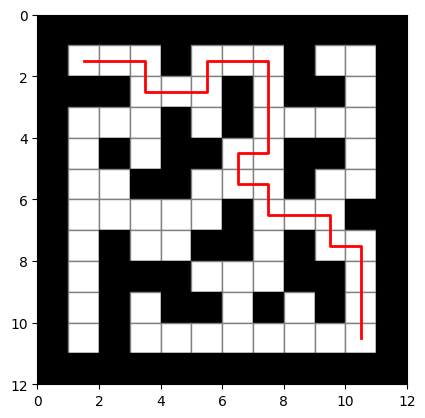

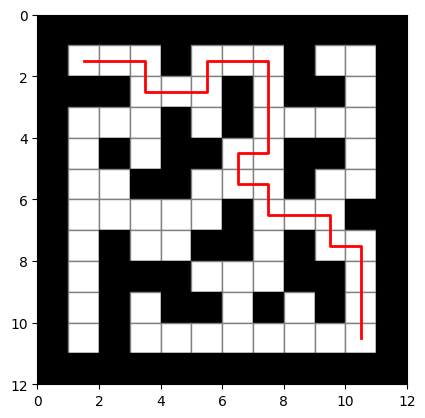

In [13]:
def main_new():
    """Main function executing, applying the genetic algorithm to the maze
    according to the settings in global variables and using the visualization
    functions defined in the Visualisation part script above."""
    fitness_list = []
    times = []
    output_list = []
    generations_no = []  # generation number in a given iteration in which the best solution was achieved

    for i in tqdm.tqdm(range(10)):
        start = time()  # we check the time at the start

        ga_instance = pygad.GA(
            gene_space=gene_space,
            num_genes=num_genes,
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=fitness_fun_new,
            sol_per_pop=sol_per_pop,
            parent_selection_type=selection,
            mutation_type=mutation,
            mutation_probability=mutation_prob,
            stop_criteria=stop_criteria,
            suppress_warnings=True,
            K_tournament=k_tournament
        )

        ga_instance.run()  # we run the genetic algorithm
        end = time()  # we measure time at the end
        times.append(end - start)

        """We manually visualize fitness history across generations."""
        fig, ax = plt.subplots()  # we create a separate figure for fitness history charts
        fitness = ga_instance.best_solutions_fitness  # values ​​on axis 0y
        generations = list(range(len(fitness)))  # values ​​on axis 0x

        ax.plot(generations, fitness, color="lime", linewidth=4, drawstyle='steps-post', label='Fitness')

        ax.set_xlabel("Generations")
        ax.set_ylabel("Fitness")
        ax.set_title("PyGAD - Generations vs. Fitness")
        ax.legend()
        ax.grid(True)
        plt.show()

        """We remember the solution parameters:"""
        solution, solution_fitness, solution_idx = ga_instance.best_solution()
        generations_no.append(ga_instance.best_solution_generation)
        fitness_list.append(solution_fitness)
        output_list.append(solution)

        """We visualize the results (the routes that the chromosomes wanted to take)"""
        gif_filename = 'chromosome_animation' + str(i) + '.gif'
        picture_filename = 'chromosome_picture' + str(i) + '.png'
        see_route(labyrinth=labyrinth, moves_mapping=moves_mapping, steps=output_list[-1],
                  gif_filename=gif_filename, summary_filename=picture_filename)

        """We visualize the actual route, omitting the steps of entering a prohibited field"""
        x, y = 1, 1
        history = []

        for step in output_list[-1]:
            new_y, new_x = y + moves_mapping.get(step)[0], x + moves_mapping.get(step)[1]
            if 0 <= new_y <= 11 and 0 <= new_x <= 11:
                """After verifying that the new coordinates are inside the maze (i.e., they fit into the matrix),
                we check if they represent a legal field:
                """
                if labyrinth[new_y, new_x] == 0:
                    x, y = new_x, new_y
                    history.append(step)
                else:
                    history.append(0)
            else:
                print(f"We got the coordinates x={new_x} and y={new_y} outside the maze (with visualization).")

        gif_filename = 'actual_route_animation' + str(i) + '.gif'
        picture_filename = 'actual_route_picture' + str(i) + '.png'
        see_route(labyrinth=labyrinth, moves_mapping=moves_mapping, steps=history,
                  gif_filename=gif_filename, summary_filename=picture_filename)

    print(f"Average running time of genetic algorithm: {np.mean(times)}")
    print(f"Average fitness value of the best solution: {np.mean(fitness_list)}")
    print(f"Average number of generations to obtain the best solution:{np.mean(generations_no)}")

    print(f"Results history: \n")
    for j in range(len(output_list)):
        print(output_list[j])


if __name__ == "__main__":
    main_new()